In [1]:
import intake
import numpy as np
data_catalog = intake.open_esm_datastore("/g/data/dk92/catalog/v2/esm/era5-rt52/catalog.json")

In [2]:
from dask.distributed import Client

In [3]:
client = Client(threads_per_worker=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43565 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43565/status,
Dashboard: /proxy/43565/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35443,Workers: 12
Dashboard: /proxy/43565/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:45859,Total threads: 1
Dashboard: /proxy/42697/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:37449,


In [5]:
data_catalog

,unique
path,801972
file_type,1
product,13
variable,306
stream,8
levtype,3
time_range,1306
derived_variable,0


In [6]:
data_catalog.description

In [6]:
data_catalog.search(product="era5-reanalysis")

,unique
path,269486
file_type,1
product,1
variable,280
stream,2
levtype,2
time_range,1011
derived_variable,0


In [7]:
data_catalog.df.variable

0             vike
1            vitoe
2            vitoe
3            vitoe
4            vitoe
            ...   
801967         mcc
801968       istl1
801969        slor
801970        slor
801971    msdwuvrf
Name: variable, Length: 801972, dtype: object

In [8]:
np.unique(data_catalog.search(variable="2t").df.stream)

array(['mnth', 'moda', 'oper'], dtype=object)

In [9]:
data_catalog.search(product="era5-reanalysis", variable="2t").to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_type.product.variable.stream.levtype'


{'f.era5-reanalysis.2t.oper.sfc': <xarray.Dataset> Size: 6TB
 Dimensions:    (longitude: 1440, latitude: 721, time: 737784)
 Coordinates:
   * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
   * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
   * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2024-02-29T23:00:00
     t2m        (time, latitude, longitude) float64 6TB dask.array<chunksize=(93, 91, 180), meta=np.ndarray>
 Data variables:
     *empty*
 Attributes:
     Conventions:                     CF-1.6
     license:                         Licence to use Copernicus Products: http...
     summary:                         ERA5 is the fifth generation ECMWF atmos...
     intake_esm_vars:                 ['2t']
     intake_esm_attrs:file_type:      f
     intake_esm_attrs:product:        era5-reanalysis
     intake_esm_attrs:variable:       2t
     intake_esm_attrs:stream:         oper
     intake_esm_attrs:levtype:        sfc
    

In [10]:
t2_ds = data_catalog.search(product="era5-reanalysis", variable="2t").to_dask()

In [11]:
t2_ds

<xarray.Dataset> Size: 6TB
Dimensions:    (longitude: 1440, latitude: 721, time: 737784)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 6MB 1940-01-01 ... 2024-02-29T23:00:00
    t2m        (time, latitude, longitude) float64 6TB dask.array<chunksize=(93, 91, 180), meta=np.ndarray>
Data variables:
    *empty*
Attributes:
    Conventions:                     CF-1.6
    license:                         Licence to use Copernicus Products: http...
    summary:                         ERA5 is the fifth generation ECMWF atmos...
    intake_esm_vars:                 ['2t']
    intake_esm_attrs:file_type:      f
    intake_esm_attrs:product:        era5-reanalysis
    intake_esm_attrs:variable:       2t
    intake_esm_attrs:stream:         oper
    intake_esm_attrs:levtype:        sfc
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          f.era5-reanalysis.2t.oper.sfc

Why is t2m a coord?



In [12]:
t2_ds['t2m_var']=t2_ds.t2m

t2_ds=t2_ds.drop_vars('t2m')

t2_ds=t2_ds.rename({'t2m_var':'t2m'})

Let convert to daily

In [13]:
t2_daily_ds = t2_ds.resample(time="D").mean("time")

In [14]:
t2_daily_ds

<xarray.Dataset> Size: 255GB
Dimensions:    (time: 30741, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 246kB 1940-01-01 1940-01-02 ... 2024-02-29
Data variables:
    t2m        (time, latitude, longitude) float64 255GB dask.array<chunksize=(7, 91, 180), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    license:                         Licence to use Copernicus Products: http...
    summary:                         ERA5 is the fifth generation ECMWF atmos...
    intake_esm_vars:                 ['2t']
    intake_esm_attrs:file_type:      f
    intake_esm_attrs:product:        era5-reanalysis
    intake_esm_attrs:variable:       2t
    intake_esm_attrs:stream:         oper
    intake_esm_attrs:levtype:        sfc
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          f.era5-reanalysis.2t.oper.sfc

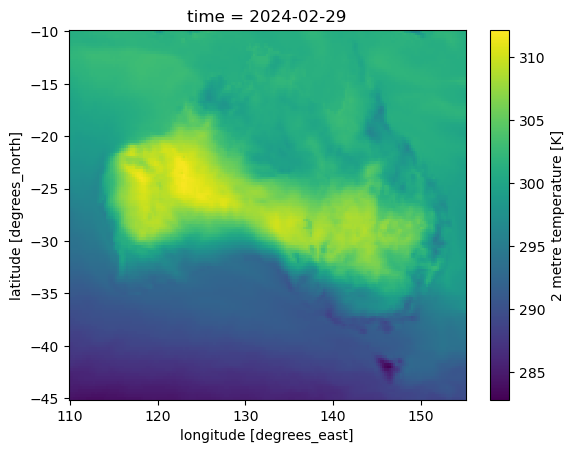

In [15]:
#Say we only want the data for Australia
t2_daily_ds.sel(longitude=slice(110,155), latitude=slice(-10,-45)).isel(time=-1).t2m.plot()

In [16]:
search = data_catalog.search(product="era5-reanalysis", variable="sst")

In [17]:
search.df.path[0]

'/g/data/rt52/era5/single-levels/reanalysis/sst/1973/sst_era5_oper_sfc_19730201-19730228.nc'

In [18]:
sst_ds = data_catalog.search(product="era5-reanalysis", variable="sst", path=search.df.path[0]).to_dask()

In [19]:
land_mask = (sst_ds.sst.isel(time=0).isnull())

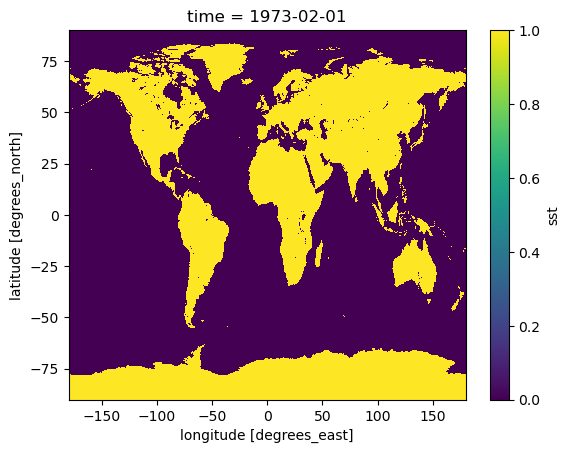

In [20]:
land_mask.plot()

In [21]:
t2_daily_aus = t2_daily_ds.where(land_mask).sel(longitude=slice(110,155), latitude=slice(-11,-45)).t2m

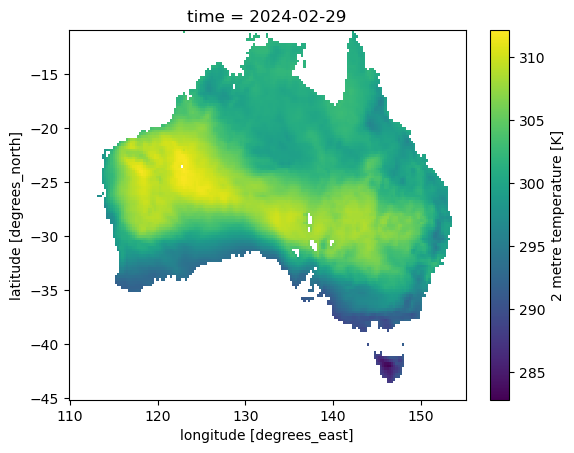

In [22]:
t2_daily_aus.isel(time=-1).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 62.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


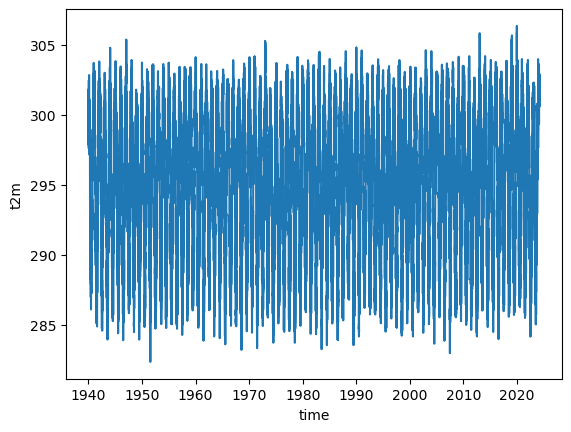

In [23]:
t2_daily_aus.mean(["longitude","latitude"]).chunk('auto').plot()